In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

In [7]:
df2 = pd.read_csv("preprocessed_data_v3_human.csv")
df2

,index,Device_Code,age,Hemoglobin_A1c,height_m,weight_kg,BMI,obesity_category,sex_F,sex_M,race_AMERICAN INDIAN/ALASKAN NATIVE,race_ASIAN,race_BLACK/AFRICAN AMERICAN,race_MULTIPLE,race_UNKNOWN,race_WHITE,ethnicity_Hispanic or Latino,ethnicity_Not Hispanic or Latino,ethnicity_UNKNOWN,insulin_delivery_MULTIPLE DAILY INJECTIONS,insulin_delivery_PUMP OR CLOSED LOOP,measure_sequence,Physicial_Activity,Calories_Burned,Heart_Rate,Insulin,Dietary_Total_Carbohydrate,Glucose,month,day,day_name,hour,hour_name,Insulin_Category,Dietary_Category
0,100,0,14.0,10.9,1.7526,70.30676,22.889245,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1.0,0,0.0,82.70864,0.0,0.0,125.666667,8,10,2,1,1,0,0
1,100,0,14.0,10.9,1.7526,70.30676,22.889245,1,0,1,0,1,0,0,0,0,0,1,0,1,0,2.0,0,0.0,82.70864,0.0,0.0,125.000000,8,10,2,2,1,0,0
2,100,0,14.0,10.9,1.7526,70.30676,22.889245,1,0,1,0,1,0,0,0,0,0,1,0,1,0,3.0,0,0.0,82.70864,0.0,0.0,159.654188,8,10,2,2,1,0,0
3,100,0,14.0,10.9,1.7526,70.30676,22.889245,1,0,1,0,1,0,0,0,0,0,1,0,1,0,4.0,0,0.0,82.70864,0.0,0.0,125.000000,8,10,2,2,1,0,0
4,100,0,14.0,10.9,1.7526,70.30676,22.889245,1,0,1,0,1,0,0,0,0,0,1,0,1,0,5.0,0,0.0,82.70864,0.0,0.0,130.333333,8,10,2,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41466,86,0,12.0,7.9,1.6510,54.43104,19.968824,1,0,1,0,0,0,0,0,1,0,1,0,1,0,917.0,0,0.0,82.70864,0.0,0.0,182.666667,6,10,4,22,8,0,0
41467,86,0,12.0,7.9,1.6510,54.43104,19.968824,1,0,1,0,0,0,0,0,1,0,1,0,1,0,918.0,0,0.0,82.70864,0.0,0.0,182.333333,6,10,4,23,8,0,0
41468,86,0,12.0,7.9,1.6510,54.43104,19.968824,1,0,1,0,0,0,0,0,1,0,1,0,1,0,919.0,0,0.0,82.70864,0.0,0.0,183.000000,6,10,4,23,8,0,0
41469,86,0,12.0,7.9,1.6510,54.43104,19.968824,1,0,1,0,0,0,0,0,1,0,1,0,1,0,920.0,0,0.0,82.70864,0.0,0.0,183.666667,6,10,4,23,8,0,0


In [8]:
df2['avg_3categories'] = df2[['Dietary_Category', 'Insulin_Category', 'Physicial_Activity']].mean(axis=1)
(df2['avg_3categories'].value_counts() / len(df2)) * 100

avg_3categories
0.000000    95.517349
0.333333     1.540836
1.000000     1.475730
0.666667     0.909069
1.333333     0.347231
1.666667     0.209785
Name: count, dtype: float64

In [9]:
value_counts = df2['Dietary_Category'].value_counts()
(value_counts / len(df2)) * 100

Dietary_Category
0    98.456753
2     0.836729
1     0.706518
Name: count, dtype: float64

In [10]:
value_counts = df2['Insulin_Category'].value_counts()
(value_counts / len(df2)) * 100

Insulin_Category
0    96.303441
3     1.396156
1     1.388922
2     0.911480
Name: count, dtype: float64

In [11]:
value_counts = df2['Physicial_Activity'].value_counts()
(value_counts / len(df2)) * 100

Physicial_Activity
0    99.556316
1     0.443684
Name: count, dtype: float64

In [12]:
df2['index'].nunique()

37

## data preprocessing: x and y for both models

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical

In [14]:
# Step 1: Split data into train and test sets based on unique patient index
random_seed = 42
unique_patients = df2['index'].unique()
train_patients, test_patients = train_test_split(unique_patients, test_size=0.2, random_state=random_seed)

train_data = df2[df2['index'].isin(train_patients)]
test_data = df2[df2['index'].isin(test_patients)]

In [15]:
train_patients

array([ 35, 286, 197, 284, 237, 458, 208, 317, 100, 443, 167, 220, 102,
       387, 329, 125,  86, 502, 133, 497, 334, 441, 209, 332, 311, 328,
       194, 264,  40])

In [16]:
test_patients

array([301, 256, 140, 436,  67, 354, 171, 360])

In [17]:
# Step 2: Features for the machine learning model
features = [
    'age', 'Hemoglobin_A1c', 'height_m', 'weight_kg', 'BMI', 'obesity_category', 'sex_F', 'sex_M', 
    'Physicial_Activity', 'Calories_Burned', 'race_AMERICAN INDIAN/ALASKAN NATIVE', 'race_ASIAN', 
    'race_BLACK/AFRICAN AMERICAN', 'race_MULTIPLE', 'race_UNKNOWN', 'race_WHITE', 
    'ethnicity_Hispanic or Latino', 'ethnicity_Not Hispanic or Latino', 'ethnicity_UNKNOWN', 
    'Heart_Rate', 'Insulin', 'Dietary_Total_Carbohydrate', 'Glucose', 'month', 'day', 'day_name', 
    'hour', 'hour_name']

In [18]:
# Step 3: Create sequences with sliding window
def create_sequences(data, features, seq_length, slide_step, glucose_prediction_length):
    sequences = []
    insulin_targets = []
    dietary_targets = []
    glucose_targets = []
    activity_targets = []
    
    for patient_id in data['index'].unique():
        patient_data = data[data['index'] == patient_id].sort_values(by='measure_sequence')

        for start in range(0, len(patient_data) - seq_length, slide_step):
            seq_input = patient_data.iloc[start:start + seq_length][features].values
            
            # Targets: next 15 min Insulin_Category, next 15 min Dietary_Category, next hour Glucose fluctuation
            next_15m_insulin = patient_data.iloc[start + seq_length]['Insulin_Category']
            next_15m_dietary = patient_data.iloc[start + seq_length]['Dietary_Category']
            next_15m_activity = patient_data.iloc[start + seq_length]['Physicial_Activity']
            next_hour_glucose = patient_data.iloc[start + seq_length:start + seq_length + glucose_prediction_length]['Glucose'].values

            if len(next_hour_glucose) == glucose_prediction_length:  # Ensure sufficient data for next hour's glucose
                # data selection: only select the best data which the selected actions lead to stable glucose after x hours
                num_in_range = np.sum((next_hour_glucose >= 80) & (next_hour_glucose <= 180))
                if num_in_range > glucose_prediction_length * 0.5:
                    sequences.append(seq_input)
                    insulin_targets.append(next_15m_insulin)
                    dietary_targets.append(next_15m_dietary)
                    activity_targets.append(next_15m_activity)
                    glucose_targets.append(next_hour_glucose)

    return (
        np.array(sequences),
        np.array(insulin_targets),
        np.array(dietary_targets),
        np.array(activity_targets),
        np.array(glucose_targets))  

In [19]:
historical_time_window = 60*4
sliding_window = 1
glucose_time_window = 6*4

In [20]:
# Generate sequences and targets for testing
test_sequences, test_insulin_targets, test_dietary_targets, test_activity_targets, test_glucose_targets = create_sequences(
    test_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window)

In [21]:
# Generate sequences and targets for training 
train_sequences, train_insulin_targets, train_dietary_targets, train_activity_targets, train_glucose_targets = create_sequences(
    train_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window)

In [22]:
test_sequences

array([[[15.    , 10.2   ,  1.6764, ...,  6.    ,  0.    ,  1.    ],
        [15.    , 10.2   ,  1.6764, ...,  6.    ,  0.    ,  1.    ],
        [15.    , 10.2   ,  1.6764, ...,  6.    ,  0.    ,  1.    ],
        ...,
        [15.    , 10.2   ,  1.6764, ...,  1.    , 11.    ,  4.    ],
        [15.    , 10.2   ,  1.6764, ...,  1.    , 11.    ,  4.    ],
        [15.    , 10.2   ,  1.6764, ...,  1.    , 12.    ,  5.    ]],

       [[15.    , 10.2   ,  1.6764, ...,  6.    ,  0.    ,  1.    ],
        [15.    , 10.2   ,  1.6764, ...,  6.    ,  0.    ,  1.    ],
        [15.    , 10.2   ,  1.6764, ...,  6.    ,  1.    ,  1.    ],
        ...,
        [15.    , 10.2   ,  1.6764, ...,  1.    , 11.    ,  4.    ],
        [15.    , 10.2   ,  1.6764, ...,  1.    , 12.    ,  5.    ],
        [15.    , 10.2   ,  1.6764, ...,  1.    , 12.    ,  5.    ]],

       [[15.    , 10.2   ,  1.6764, ...,  6.    ,  0.    ,  1.    ],
        [15.    , 10.2   ,  1.6764, ...,  6.    ,  1.    ,  1.    ],
    

In [23]:
test_insulin_targets

array([0., 0., 0., ..., 0., 0., 3.])

In [24]:
test_dietary_targets

array([0., 0., 0., ..., 0., 0., 1.])

In [25]:
test_glucose_targets

array([[302.        , 319.66666667, 359.33333333, ..., 159.6541879 ,
        157.33333333, 127.66666667],
       [319.66666667, 359.33333333, 374.33333333, ..., 157.33333333,
        127.66666667, 126.        ],
       [359.33333333, 374.33333333, 383.        , ..., 127.66666667,
        126.        ,  97.        ],
       ...,
       [144.33333333, 107.        , 100.66666667, ..., 137.33333333,
        162.        , 164.66666667],
       [107.        , 100.66666667, 124.33333333, ..., 162.        ,
        164.66666667, 172.33333333],
       [100.66666667, 124.33333333, 194.33333333, ..., 164.66666667,
        172.33333333, 173.5       ]])

In [26]:
# Output the shape of prepared data
print("Train sequences shape:", train_sequences.shape)
print("Train insulin targets shape:", train_insulin_targets.shape)
print("Train dietary targets shape:", train_dietary_targets.shape)
print("Train activity targets shape:", train_activity_targets.shape)
print("Train glucose targets shape:", train_glucose_targets.shape)

print("Test sequences shape:", test_sequences.shape)
print("Test insulin targets shape:", test_insulin_targets.shape)
print("Test dietary targets shape:", test_dietary_targets.shape)
print("Test activity targets shape:", test_activity_targets.shape)
print("Test glucose targets shape:", test_glucose_targets.shape)

Train sequences shape: (18261, 240, 28)
Train insulin targets shape: (18261,)
Train dietary targets shape: (18261,)
Train activity targets shape: (18261,)
Train glucose targets shape: (18261, 24)
Test sequences shape: (3594, 240, 28)
Test insulin targets shape: (3594,)
Test dietary targets shape: (3594,)
Test activity targets shape: (3594,)
Test glucose targets shape: (3594, 24)


In [27]:
from sklearn.neighbors import NearestNeighbors

In [28]:
def oversample_minority_classes(X, y_insulin, y_dietary, y_activity, y_glucose):
    """Simple oversampling that preserves all original classes"""
    
    # Prepare data
    num_samples, seq_length, features = X.shape
    X_flat = X.reshape(num_samples, -1)
    
    # Convert to integer labels if needed
    if len(y_insulin.shape) == 1:
        insulin_labels = y_insulin.astype(int)
        dietary_labels = y_dietary.astype(int)
        activity_labels = y_activity.astype(int)
    else:
        insulin_labels = np.argmax(y_insulin, axis=1)
        dietary_labels = np.argmax(y_dietary, axis=1)
        activity_labels = np.argmax(y_activity, axis=1)
    
    # Ensure we're using the correct number of classes
    num_insulin_classes = len(np.unique(y_insulin))
    num_dietary_classes = len(np.unique(y_dietary))
    num_activity_classes = len(np.unique(y_activity))
    
    # Print original distributions
    print("Original distributions:")
    for name, labels in [("Insulin", insulin_labels), 
                         ("Dietary", dietary_labels), 
                         ("Activity", activity_labels)]:
        class_counts = np.bincount(labels, minlength=4)
        print(f"{name} counts: {class_counts}")
    
    # Process each target separately
    # For insulin
    insulin_balanced_X = []
    insulin_balanced_y = []
    
    # Get sample count for each insulin class
    insulin_counts = np.bincount(insulin_labels, minlength=num_insulin_classes)
    # Determine target count (using max class size)
    insulin_target = np.max(insulin_counts)
    
    # Balance each class
    for class_idx in range(num_insulin_classes):
        # Skip if no samples
        if insulin_counts[class_idx] == 0:
            continue
            
        # Get samples of this class
        idx = np.where(insulin_labels == class_idx)[0]
        
        # Sample with replacement to reach target count
        if len(idx) < insulin_target:
            # Need to oversample
            sampled_idx = np.random.choice(idx, size=insulin_target, replace=True)
        else:
            # Already have enough, take random subset
            sampled_idx = np.random.choice(idx, size=insulin_target, replace=False)
            
        # Add to balanced dataset
        insulin_balanced_X.append(X_flat[sampled_idx])
        insulin_balanced_y.append(np.full(insulin_target, class_idx))
    
    # Combine all classes
    insulin_balanced_X = np.vstack(insulin_balanced_X)
    insulin_balanced_y = np.concatenate(insulin_balanced_y)
    
    # Convert to one-hot
    insulin_balanced_onehot = np.zeros((len(insulin_balanced_y), num_insulin_classes))
    for i, label in enumerate(insulin_balanced_y):
        insulin_balanced_onehot[i, label] = 1
    
    # Repeat the same process for dietary
    dietary_balanced_X = []
    dietary_balanced_y = []
    
    dietary_counts = np.bincount(dietary_labels, minlength=num_dietary_classes)
    dietary_target = np.max(dietary_counts)
    
    for class_idx in range(num_dietary_classes):
        if dietary_counts[class_idx] == 0:
            continue
            
        idx = np.where(dietary_labels == class_idx)[0]
        
        if len(idx) < dietary_target:
            sampled_idx = np.random.choice(idx, size=dietary_target, replace=True)
        else:
            sampled_idx = np.random.choice(idx, size=dietary_target, replace=False)
            
        dietary_balanced_X.append(X_flat[sampled_idx])
        dietary_balanced_y.append(np.full(dietary_target, class_idx))
    
    dietary_balanced_X = np.vstack(dietary_balanced_X)
    dietary_balanced_y = np.concatenate(dietary_balanced_y)
    
    dietary_balanced_onehot = np.zeros((len(dietary_balanced_y), num_dietary_classes))
    for i, label in enumerate(dietary_balanced_y):
        dietary_balanced_onehot[i, label] = 1
    
    # Repeat for activity
    activity_balanced_X = []
    activity_balanced_y = []
    
    activity_counts = np.bincount(activity_labels, minlength=num_activity_classes)
    activity_target = np.max(activity_counts)
    
    for class_idx in range(num_activity_classes):
        if activity_counts[class_idx] == 0:
            continue
            
        idx = np.where(activity_labels == class_idx)[0]
        
        if len(idx) < activity_target:
            sampled_idx = np.random.choice(idx, size=activity_target, replace=True)
        else:
            sampled_idx = np.random.choice(idx, size=activity_target, replace=False)
            
        activity_balanced_X.append(X_flat[sampled_idx])
        activity_balanced_y.append(np.full(activity_target, class_idx))
    
    activity_balanced_X = np.vstack(activity_balanced_X)
    activity_balanced_y = np.concatenate(activity_balanced_y)
    
    activity_balanced_onehot = np.zeros((len(activity_balanced_y), num_activity_classes))
    for i, label in enumerate(activity_balanced_y):
        activity_balanced_onehot[i, label] = 1
    
    # Now we need to consolidate into a single dataset
    # We'll use random indices from each balanced set
    insulin_size = len(insulin_balanced_X)
    
    # Reshape X back to 3D
    X_final = insulin_balanced_X.reshape(-1, seq_length, features)
    
    # Use the corresponding balanced targets
    insulin_final = insulin_balanced_onehot
    
    # For dietary and activity, sample to match insulin size
    # If smaller, sample with replacement
    if len(dietary_balanced_onehot) < insulin_size:
        dietary_indices = np.random.choice(len(dietary_balanced_onehot), 
                                         size=insulin_size, replace=True)
    else:
        dietary_indices = np.random.choice(len(dietary_balanced_onehot), 
                                         size=insulin_size, replace=False)
    
    dietary_final = dietary_balanced_onehot[dietary_indices]
    
    if len(activity_balanced_onehot) < insulin_size:
        activity_indices = np.random.choice(len(activity_balanced_onehot), 
                                          size=insulin_size, replace=True)
    else:
        activity_indices = np.random.choice(len(activity_balanced_onehot), 
                                          size=insulin_size, replace=False)
    
    activity_final = activity_balanced_onehot[activity_indices]
    
    # Map glucose values using nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=1).fit(X_flat)
    _, indices = nbrs.kneighbors(X_final.reshape(insulin_size, -1))
    glucose_final = y_glucose[indices.flatten()]
    
    # Check final distributions
    print("\nFinal distributions:")
    for name, onehot in [("Insulin", insulin_final), 
                         ("Dietary", dietary_final), 
                         ("Activity", activity_final)]:
        labels = np.argmax(onehot, axis=1)
        class_counts = np.bincount(labels, minlength=4)
        print(f"{name} counts: {class_counts}")
    
    return X_final, insulin_final, dietary_final, activity_final, glucose_final

In [29]:
def get_percent(arr):
    unique_vals, counts = np.unique(arr, return_counts=True)
    
    # Calculate percentages
    percentages = (counts / arr.size) * 100
    
    # Print the results
    for value, perc in zip(unique_vals, percentages):
        print(f"Value {value}: {perc:.2f}%")

In [30]:
ts_sequences, ts_insulin_targets, ts_dietary_targets, ts_activity_targets, ts_glucose_targets = oversample_minority_classes(
    test_sequences, test_insulin_targets, test_dietary_targets, test_activity_targets, test_glucose_targets)

Original distributions:
Insulin counts: [3459   69   33   33]
Dietary counts: [3520   35   39    0]
Activity counts: [3585    9    0    0]

Final distributions:
Insulin counts: [3459 3459 3459 3459]
Dietary counts: [4637 4727 4472    0]
Activity counts: [6961 6875    0    0]


In [31]:
ts_sequences, ts_glucose_targets = test_sequences.copy(), test_glucose_targets.copy()

num_classes_insulin = df2['Insulin_Category'].nunique()
num_classes_dietary = df2['Dietary_Category'].nunique()
num_classes_activity = df2['Physicial_Activity'].nunique()

ts_insulin_targets = to_categorical(test_insulin_targets, num_classes=num_classes_insulin)
ts_dietary_targets = to_categorical(test_dietary_targets, num_classes=num_classes_dietary)
ts_activity_targets = to_categorical(test_activity_targets, num_classes=num_classes_activity)

In [32]:
tr_sequences, tr_insulin_targets, tr_dietary_targets, tr_activity_targets, tr_glucose_targets = oversample_minority_classes(
    train_sequences, train_insulin_targets, train_dietary_targets, train_activity_targets, train_glucose_targets)

Original distributions:
Insulin counts: [17700   205   146   210]
Dietary counts: [18036   110   115     0]
Activity counts: [18146   115     0     0]

Final distributions:
Insulin counts: [17700 17700 17700 17700]
Dietary counts: [23533 23468 23799     0]
Activity counts: [35368 35432     0     0]


In [33]:
# Output the shape of prepared data
print("Train sequences shape:", tr_sequences.shape)
print("Train insulin targets shape:", tr_insulin_targets.shape)
print("Train dietary targets shape:", tr_dietary_targets.shape)
print("Train activity targets shape:", tr_activity_targets.shape)
print("Train glucose targets shape:", tr_glucose_targets.shape)

print("Test sequences shape:", ts_sequences.shape)
print("Test insulin targets shape:", ts_insulin_targets.shape)
print("Test dietary targets shape:", ts_dietary_targets.shape)
print("Test activity targets shape:", ts_activity_targets.shape)
print("Test glucose targets shape:", ts_glucose_targets.shape)

Train sequences shape: (70800, 240, 28)
Train insulin targets shape: (70800, 4)
Train dietary targets shape: (70800, 3)
Train activity targets shape: (70800, 2)
Train glucose targets shape: (70800, 24)
Test sequences shape: (3594, 240, 28)
Test insulin targets shape: (3594, 4)
Test dietary targets shape: (3594, 3)
Test activity targets shape: (3594, 2)
Test glucose targets shape: (3594, 24)


### other preprocessing

In [34]:
# Scale glucose targets (4 values per output, reshape appropriately)
glucose_scaler = MinMaxScaler()

tr_glucose_targets = glucose_scaler.fit_transform(
    tr_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)

ts_glucose_targets = glucose_scaler.transform(
    ts_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)

In [35]:
# Reverse scale glucose predictions
# predicted_glucose = glucose_scaler.inverse_transform(predicted_glucose.reshape(-1, 1)).reshape(-1, 4)

In [36]:
# Function to scale input sequences
def scale_sequences(train_sequences, test_sequences):
    # Reshape to 2D for scaling: (num_samples * seq_length, num_features)
    num_samples_train, seq_length, num_features = train_sequences.shape
    num_samples_test = test_sequences.shape[0]

    train_reshaped = train_sequences.reshape(-1, num_features)
    test_reshaped = test_sequences.reshape(-1, num_features)

    # Initialize MinMaxScaler
    sequence_scaler = MinMaxScaler()

    # Fit scaler on training data and transform both train and test
    train_scaled = sequence_scaler.fit_transform(train_reshaped)
    test_scaled = sequence_scaler.transform(test_reshaped)

    # Reshape back to original shape
    train_scaled = train_scaled.reshape(num_samples_train, seq_length, num_features)
    test_scaled = test_scaled.reshape(num_samples_test, seq_length, num_features)

    return train_scaled, test_scaled, sequence_scaler

In [37]:
# Scale input sequences
tr_sequences, ts_sequences, sequence_scaler = scale_sequences(tr_sequences, ts_sequences)

In [38]:
# Output the shape of prepared data
print("Train sequences shape:", tr_sequences.shape)
print("Train insulin targets shape:", tr_insulin_targets.shape)
print("Train dietary targets shape:", tr_dietary_targets.shape)
print("Train activity targets shape:", tr_activity_targets.shape)
print("Train glucose targets shape:", tr_glucose_targets.shape)

print("Test sequences shape:", ts_sequences.shape)
print("Test insulin targets shape:", ts_insulin_targets.shape)
print("Test dietary targets shape:", ts_dietary_targets.shape)
print("Test activity targets shape:", ts_activity_targets.shape)
print("Test glucose targets shape:", ts_glucose_targets.shape)

Train sequences shape: (70800, 240, 28)
Train insulin targets shape: (70800, 4)
Train dietary targets shape: (70800, 3)
Train activity targets shape: (70800, 2)
Train glucose targets shape: (70800, 24)
Test sequences shape: (3594, 240, 28)
Test insulin targets shape: (3594, 4)
Test dietary targets shape: (3594, 3)
Test activity targets shape: (3594, 2)
Test glucose targets shape: (3594, 24)


## models

In [39]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [40]:
time_series_length = tr_sequences.shape[1]
feature_dim = tr_sequences.shape[2]
num_insulin_classes = df2['Insulin_Category'].nunique()
num_activity_classes = df2['Physicial_Activity'].nunique()
num_dietary_classes = df2['Dietary_Category'].nunique()
output_dim = tr_glucose_targets.shape[1]  # Features in the sequence prediction output

In [36]:
print(time_series_length)
print(feature_dim)
print(num_insulin_classes)
print(num_activity_classes)
print(num_dietary_classes)
print(output_dim)

240
28
4
2
3
24


In [37]:
def create_joint_learning_model():
    # Input layer for time series data
    input_time_series = layers.Input(shape=(time_series_length, feature_dim), name='time_series_input')
    
    # First Model: Predicting insulin and dietary categories
    # Shared layers for both predictions
    x1 = layers.LSTM(80, return_sequences=True)(input_time_series)
    x1 = layers.LSTM(60, return_sequences=True)(x1)
    x1 = layers.LSTM(40)(x1)
    shared_dense = layers.Dense(20, activation='relu')(x1)
    
    # Separate branches for insulin and dietary predictions
    insulin_branch = layers.Dense(10, activation='relu')(shared_dense)
    insulin_output = layers.Dense(num_insulin_classes, activation='softmax', name='insulin_output')(insulin_branch)
    
    dietary_branch = layers.Dense(10, activation='relu')(shared_dense)
    dietary_output = layers.Dense(num_dietary_classes, activation='softmax', name='dietary_output')(dietary_branch)

    activity_branch = layers.Dense(10, activation='relu')(shared_dense)
    activity_output = layers.Dense(num_activity_classes, activation='softmax', name='activity_output')(activity_branch)
    
    # Second Model: Predicting glucose sequence
    # Combine predicted labels
    predicted_labels = layers.Concatenate(axis=-1)([insulin_output, dietary_output, activity_output])
    
    # Reshape labels to match time series length
    repeated_labels = layers.RepeatVector(time_series_length)(predicted_labels)
    
    # Combine time series with predicted labels
    combined_input = layers.Concatenate(axis=-1)([input_time_series, repeated_labels])
    
    # Glucose prediction layers
    x2 = layers.LSTM(80, return_sequences=True)(combined_input)
    x2 = layers.LSTM(60, return_sequences=True)(x2)
    x2 = layers.LSTM(40, return_sequences=True)(x2)
    x2 = layers.LSTM(20, return_sequences=True)(x2)
    x2 = layers.TimeDistributed(layers.Dense(10, activation='relu'))(x2)
    glucose_output = layers.Dense(output_dim, name='glucose_output')(x2[:, -1, :])  # Only use last time step
    
    # Create unified model
    model = Model(
        inputs=input_time_series,
        outputs=[insulin_output, dietary_output, activity_output, glucose_output])
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss={
            'insulin_output': 'categorical_crossentropy',
            'dietary_output': 'categorical_crossentropy',
            'activity_output': 'categorical_crossentropy',
            'glucose_output': 'mse'},
        metrics={'insulin_output': ['accuracy'],
                 'dietary_output': ['accuracy'],
                 'activity_output': ['accuracy'],
                 'glucose_output': ['mae']})
    return model

In [38]:
model = create_joint_learning_model()

W0000 00:00:1752080036.427729  492442 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [39]:
# Create and train the model
def train_model(tr_sequences, tr_insulin_targets, tr_dietary_targets, tr_activity_targets, tr_glucose_targets,
                val_sequences, val_insulin_targets, val_dietary_targets, val_activity_targets, val_glucose_targets):
    
    # Create model
    model = create_joint_learning_model()
    
    # Early stopping callback
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True)
    
    # Model checkpoint callback
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        'manual_model1.keras',
        monitor='tr_loss',
        save_best_only=True,
        mode='min')

    # Train model
    history = model.fit(
        tr_sequences,
        {'insulin_output': tr_insulin_targets,
         'dietary_output': tr_dietary_targets,
         'activity_output': tr_activity_targets,
         'glucose_output': tr_glucose_targets},
        validation_data=(
            val_sequences,
            {'insulin_output': val_insulin_targets,
             'dietary_output': val_dietary_targets,
             'activity_output': val_activity_targets,
             'glucose_output': val_glucose_targets}),
        batch_size=32,
        epochs=10,
        callbacks=[early_stopping, checkpoint])
    
    return model, history

In [40]:
tr_insulin_targets

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [41]:
# Train the model
model, history = train_model(
    tr_sequences, tr_insulin_targets, tr_dietary_targets, tr_activity_targets, tr_glucose_targets,
    ts_sequences, ts_insulin_targets, ts_dietary_targets, ts_activity_targets, ts_glucose_targets)

Epoch 1/10


2025-07-09 11:54:12.212846: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


2213/2213 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - activity_output_accuracy: 0.5004 - activity_output_loss: 0.6947 - dietary_output_accuracy: 0.3327 - dietary_output_loss: 1.1012 - glucose_output_loss: 0.0191 - glucose_output_mae: 0.0952 - insulin_output_accuracy: 0.5121 - insulin_output_loss: 1.0988 - loss: 2.9137

/home/kcmnf/.conda/envs/ml_env2/lib/python3.11/site-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with tr_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


2213/2213 ━━━━━━━━━━━━━━━━━━━━ 1047s 467ms/step - activity_output_accuracy: 0.5004 - activity_output_loss: 0.6947 - dietary_output_accuracy: 0.3327 - dietary_output_loss: 1.1012 - glucose_output_loss: 0.0191 - glucose_output_mae: 0.0952 - insulin_output_accuracy: 0.5121 - insulin_output_loss: 1.0987 - loss: 2.9137 - val_activity_output_accuracy: 0.1795 - val_activity_output_loss: 0.7262 - val_dietary_output_accuracy: 0.2031 - val_dietary_output_loss: 1.1082 - val_glucose_output_loss: 0.0118 - val_glucose_output_mae: 0.0844 - val_insulin_output_accuracy: 0.3344 - val_insulin_output_loss: 1.2762 - val_loss: 3.1214
Epoch 2/10
2213/2213 ━━━━━━━━━━━━━━━━━━━━ 1448s 654ms/step - activity_output_accuracy: 0.4978 - activity_output_loss: 0.6938 - dietary_output_accuracy: 0.3357 - dietary_output_loss: 1.0996 - glucose_output_loss: 0.0059 - glucose_output_mae: 0.0527 - insulin_output_accuracy: 0.7863 - insulin_output_loss: 0.5572 - loss: 2.3565 - val_activity_output_accuracy: 0.0245 - val_activity

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



2213/2213 ━━━━━━━━━━━━━━━━━━━━ 722s 326ms/step - activity_output_accuracy: 0.5035 - activity_output_loss: 0.6932 - dietary_output_accuracy: 0.3388 - dietary_output_loss: 1.0987 - glucose_output_loss: 0.0014 - glucose_output_mae: 0.0238 - insulin_output_accuracy: 0.9427 - insulin_output_loss: 0.1839 - loss: 1.9772 - val_activity_output_accuracy: 0.0437 - val_activity_output_loss: 0.6948 - val_dietary_output_accuracy: 0.6213 - val_dietary_output_loss: 1.0990 - val_glucose_output_loss: 0.0149 - val_glucose_output_mae: 0.0948 - val_insulin_output_accuracy: 0.7315 - val_insulin_output_loss: 0.8146 - val_loss: 2.6182
Epoch 8/10
2213/2213 ━━━━━━━━━━━━━━━━━━━━ 723s 327ms/step - activity_output_accuracy: 0.5062 - activity_output_loss: 0.6931 - dietary_output_accuracy: 0.3345 - dietary_output_loss: 1.0986 - glucose_output_loss: 0.0013 - glucose_output_mae: 0.0233 - insulin_output_accuracy: 0.9510 - insulin_output_loss: 0.1615 - loss: 1.9545 - val_activity_output_accuracy: 0.9969 - val_activity_o

In [42]:
model.save('manual_model1.keras')

In [43]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ time_series_input   │ (None, 240, 28)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 240, 80)   │     34,880 │ time_series_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_8 (LSTM)       │ (None, 240, 60)   │     33,840 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 40)        │     16,160 │ lstm_8[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 20)        │        820 │ lstm_9[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 10)        │        210 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 10)        │        210 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 10)        │        210 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ insulin_output      │ (None, 4)         │         44 │ dense_6[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dietary_output      │ (None, 3)         │         33 │ dense_7[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activity_output     │ (None, 2)         │         22 │ dense_8[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 9)         │          0 │ insulin_output[0… │
│ (Concatenate)       │                   │            │ dietary_output[0… │
│                     │                   │            │ activity_output[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_1     │ (None, 240, 9)    │          0 │ concatenate_2[0]… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 240, 37)   │          0 │ time_series_inpu… │
│ (Concatenate)       │                   │            │ repeat_vector_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_10 (LSTM)      │ (None, 240, 80)   │     37,760 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_11 (LSTM)      │ (None, 240, 60)   │     33,840 │ lstm_10[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_12 (LSTM)      │ (None, 240, 40)   │     16,160 │ lstm_11[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_13 (LSTM)      │ (None, 240, 20)   │      4,880 │ lstm_12[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 240, 10)   │        210 │ lstm_13[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 10)        │          0 │ time_distributed… │
│ (GetItem)           │                   │            │                 

 Total params: 538,631 (2.05 MB)

 Trainable params: 179,543 (701.34 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 359,088 (1.37 MB)

In [44]:
# plot_model(model, to_file='model_architecture.png', show_shapes=True)

# # Display the plot
# plt.imshow(plt.imread('model_architecture.png'))
# plt.axis('off')
# plt.show()

In [45]:
insulin_pred, dietary_pred, activity_pred, glucose_pred = model.predict(ts_sequences)

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 107ms/step


In [46]:
insulin_pred

array([[9.9471903e-01, 1.2413377e-03, 3.2455516e-03, 7.9403608e-04],
       [9.9176288e-01, 2.1506215e-03, 5.0165663e-03, 1.0698531e-03],
       [9.8763114e-01, 3.9819186e-03, 7.0618191e-03, 1.3250841e-03],
       ...,
       [9.9574608e-01, 3.7989684e-03, 5.6690569e-05, 3.9823417e-04],
       [9.9695539e-01, 2.3622878e-03, 5.4697241e-05, 6.2765006e-04],
       [9.9636060e-01, 1.9783613e-03, 6.5680411e-05, 1.5953584e-03]],
      dtype=float32)

In [47]:
dietary_pred

array([[0.33758825, 0.33039322, 0.33201855],
       [0.33616775, 0.33157814, 0.33225408],
       [0.3316471 , 0.33536845, 0.33298445],
       ...,
       [0.33423585, 0.33319432, 0.3325698 ],
       [0.33758825, 0.33039322, 0.33201855],
       [0.33758825, 0.33039322, 0.33201855]], dtype=float32)

In [48]:
activity_pred

array([[0.5040152 , 0.49598482],
       [0.5040152 , 0.49598482],
       [0.5040152 , 0.49598482],
       ...,
       [0.5040152 , 0.49598482],
       [0.5040152 , 0.49598482],
       [0.5040152 , 0.49598482]], dtype=float32)

In [49]:
glucose_pred

array([[0.5567872 , 0.5539615 , 0.50753945, ..., 0.22374772, 0.21593592,
        0.21110818],
       [0.5935547 , 0.5882198 , 0.5367036 , ..., 0.23802744, 0.22824323,
        0.22140771],
       [0.61594605, 0.6104736 , 0.5566983 , ..., 0.25595787, 0.24812928,
        0.24147198],
       ...,
       [0.43162173, 0.44664472, 0.43433642, ..., 0.34469602, 0.36923867,
        0.3770263 ],
       [0.2861641 , 0.29251322, 0.29029638, ..., 0.3589528 , 0.38364282,
        0.38933444],
       [0.24254552, 0.2273924 , 0.21266775, ..., 0.38054237, 0.3913708 ,
        0.3854019 ]], dtype=float32)

In [50]:
def evaluate_unified_model(model, test_sequences, true_insulin, true_dietary, true_activity, true_glucose):
    """
    Evaluate the unified model performance
    """
    # Get predictions
    insulin_pred, dietary_pred, activity_pred, glucose_pred = model.predict(test_sequences)
    
    # Evaluate classification performance
    classification_results = {
        'insulin': {
            'classification_report': classification_report(
                np.argmax(true_insulin, axis=1),
                np.argmax(insulin_pred, axis=1)),
            'confusion_matrix': confusion_matrix(
                np.argmax(true_insulin, axis=1),
                np.argmax(insulin_pred, axis=1))},
        'dietary': {
            'classification_report': classification_report(
                np.argmax(true_dietary, axis=1),
                np.argmax(dietary_pred, axis=1)),
            'confusion_matrix': confusion_matrix(
                np.argmax(true_dietary, axis=1),
                np.argmax(dietary_pred, axis=1))},
        'activity': {
            'classification_report': classification_report(
                np.argmax(true_activity, axis=1),
                np.argmax(activity_pred, axis=1)),
            'confusion_matrix': confusion_matrix(
                np.argmax(true_activity, axis=1),
                np.argmax(activity_pred, axis=1))}}
    
    # Evaluate regression performance
    regression_results = {
        'mse': np.mean((true_glucose - glucose_pred) ** 2),
        'mae': np.mean(np.abs(true_glucose - glucose_pred)),
        'rmse': np.sqrt(np.mean((true_glucose - glucose_pred) ** 2)),
        'predictions': glucose_pred,
        'true_values': true_glucose}
    
    return classification_results, regression_results

In [51]:
def plot_confusion_matrices(results, title_prefix=''):
    """
    Plot confusion matrices for classification results
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6))
    
    # Plot insulin confusion matrix
    sns.heatmap(results['insulin']['confusion_matrix'], 
                annot=True, fmt='d', ax=ax1, cmap='Blues')
    ax1.set_title(f'{title_prefix}Insulin Confusion Matrix')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('True')
    
    # Plot dietary confusion matrix
    sns.heatmap(results['dietary']['confusion_matrix'], 
                annot=True, fmt='d', ax=ax2, cmap='Blues')
    ax2.set_title(f'{title_prefix}Dietary Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')

    sns.heatmap(results['activity']['confusion_matrix'], 
                annot=True, fmt='d', ax=ax3, cmap='Blues')
    ax2.set_title(f'{title_prefix}Activity Confusion Matrix')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('True')
        
    plt.tight_layout()
    plt.show()

In [52]:
def plot_glucose_predictions(true_values, predictions, title='Glucose Predictions'):
    """
    Plot actual vs predicted glucose values
    """
    # Plot mean predictions and actual values
    plt.figure(figsize=(10, 6))
    time_points = range(true_values.shape[1])
    
    plt.plot(time_points, np.mean(true_values, axis=0), 'b-', label='Actual (mean)')
    plt.plot(time_points, np.mean(predictions, axis=0), 'r--', label='Predicted (mean)')
    
    # Add confidence intervals
    plt.fill_between(time_points,
                    np.percentile(true_values, 25, axis=0),
                    np.percentile(true_values, 75, axis=0),
                    alpha=0.2, color='blue')
    plt.fill_between(time_points,
                    np.percentile(predictions, 25, axis=0),
                    np.percentile(predictions, 75, axis=0),
                    alpha=0.2, color='red')
    
    plt.title(title)
    plt.xlabel('Time Points (15-minute intervals)')
    plt.ylabel('Glucose Level')
    plt.legend()
    plt.grid(True)
    plt.show()

In [53]:
def evaluate_all_models(unified_model, test_sequences, test_insulin, test_dietary, test_activity, test_glucose):
    """
    Evaluate all models and display results
    """
    print("\nEvaluating Unified Model")
    print("-" * 50)
    unified_class_results, unified_reg_results = evaluate_unified_model(
        unified_model, test_sequences, test_insulin, test_dietary, test_activity, test_glucose)
    print("\nUnified Model - Classification Results:")
    print("\nInsulin Classification Report:")
    print(unified_class_results['insulin']['classification_report'])
    print("\nDietary Classification Report:")
    print(unified_class_results['dietary']['classification_report'])
    print("\nActivity Classification Report:")
    print(unified_class_results['activity']['classification_report'])
    plot_confusion_matrices(unified_class_results, "Unified Model - ")
    
    print("\nUnified Model - Regression Results:")
    print(f"MSE: {unified_reg_results['mse']:.4f}")
    print(f"MAE: {unified_reg_results['mae']:.4f}")
    print(f"RMSE: {unified_reg_results['rmse']:.4f}")
    plot_glucose_predictions(
        unified_reg_results['true_values'], 
        unified_reg_results['predictions'], 
        "Unified Model - Glucose Predictions")


Evaluating Unified Model
--------------------------------------------------
113/113 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step

Unified Model - Classification Results:

Insulin Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      3459
           1       0.05      0.30      0.09        69
           2       0.01      0.03      0.02        33
           3       0.06      0.39      0.11        33

    accuracy                           0.79      3594
   macro avg       0.27      0.38      0.27      3594
weighted avg       0.94      0.79      0.85      3594


Dietary Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.73      3520
           1       0.02      0.14      0.04        35
           2       0.00      0.10      0.01        39

    accuracy                           0.57      3594
   macro avg       0.33      0.28      0.26      3594
weighted avg  

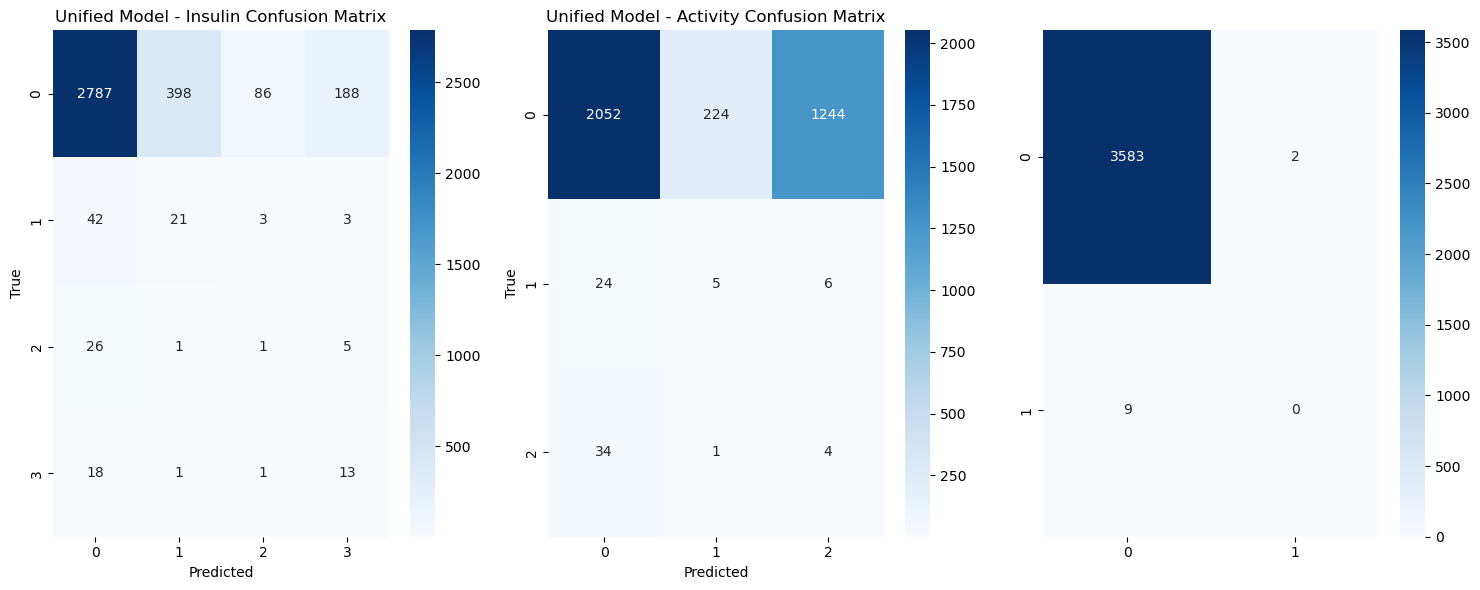


Unified Model - Regression Results:
MSE: 0.0144
MAE: 0.0928
RMSE: 0.1200


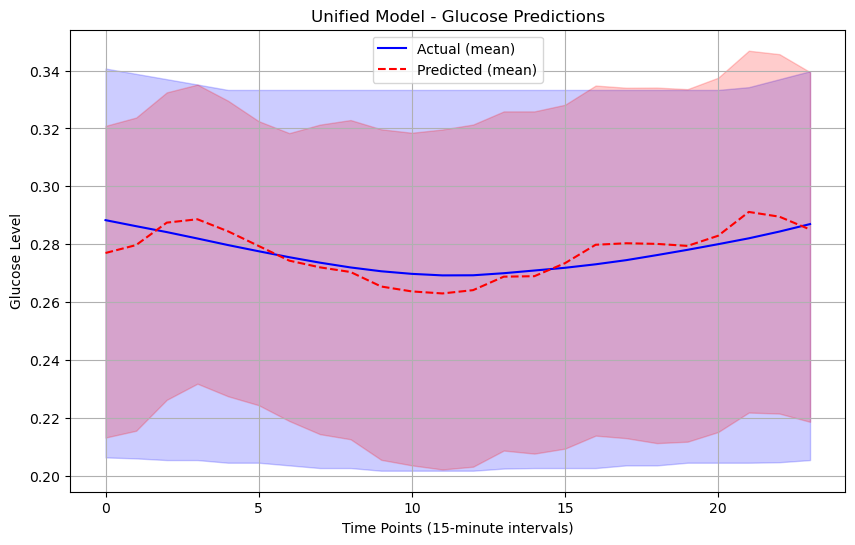

In [54]:
evaluate_all_models(model, ts_sequences, ts_insulin_targets, ts_dietary_targets, ts_activity_targets, ts_glucose_targets)

In [55]:
def plot_training_history(history, figsize=(15, 10)):
    """
    Plot training history for all metrics in the unified model
    
    Parameters:
    history: keras history object from model.fit()
    figsize: tuple, size of the figure (width, height)
    """
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=figsize)
    
    # Plot Loss Curves
    # Main loss (total loss)
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Total Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Insulin Classification
    ax2.plot(history.history['insulin_output_loss'], label='Training Loss')
    ax2.plot(history.history['val_insulin_output_loss'], label='Validation Loss')
    ax2.plot(history.history['insulin_output_accuracy'], label='Training Accuracy')
    ax2.plot(history.history['val_insulin_output_accuracy'], label='Validation Accuracy')
    ax2.set_title('Insulin Classification Metrics')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss/Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    # Dietary Classification
    ax3.plot(history.history['dietary_output_loss'], label='Training Loss')
    ax3.plot(history.history['val_dietary_output_loss'], label='Validation Loss')
    ax3.plot(history.history['dietary_output_accuracy'], label='Training Accuracy')
    ax3.plot(history.history['val_dietary_output_accuracy'], label='Validation Accuracy')
    ax3.set_title('Dietary Classification Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss/Accuracy')
    ax3.legend()
    ax3.grid(True)

    # Dietary Classification
    ax3.plot(history.history['activity_output_loss'], label='Training Loss')
    ax3.plot(history.history['val_activity_output_loss'], label='Validation Loss')
    ax3.plot(history.history['activity_output_accuracy'], label='Training Accuracy')
    ax3.plot(history.history['val_activity_output_accuracy'], label='Validation Accuracy')
    ax3.set_title('Activity Classification Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss/Accuracy')
    ax3.legend()
    ax3.grid(True)
    
    # Glucose Prediction
    ax4.plot(history.history['glucose_output_loss'], label='Training MSE')
    ax4.plot(history.history['val_glucose_output_loss'], label='Validation MSE')
    if 'glucose_output_mae' in history.history:
        ax4.plot(history.history['glucose_output_mae'], label='Training MAE')
        ax4.plot(history.history['val_glucose_output_mae'], label='Validation MAE')
    ax4.set_title('Glucose Prediction Metrics')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Error')
    ax4.legend()
    ax4.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_detailed_metrics(history, figsize=(15, 15)):
    """
    Create detailed plots for each metric separately
    
    Parameters:
    history: keras history object from model.fit()
    figsize: tuple, size of the figure (width, height)
    """
    metrics = {
        'Loss Curves': {
            'loss': 'Total Loss',
            'insulin_output_loss': 'Insulin Loss',
            'dietary_output_loss': 'Dietary Loss',
            'activity_output_loss': 'Activity Loss',
            'glucose_output_loss': 'Glucose MSE'
        },
        'Accuracy Curves': {
            'insulin_output_accuracy': 'Insulin Accuracy',
            'dietary_output_accuracy': 'Dietary Accuracy',
            'activity_output_accuracy': 'Activity Accuracy'
        },
        'Glucose Metrics': {
            'glucose_output_mae': 'Glucose MAE',
            'glucose_output_loss': 'Glucose MSE'
        }
    }
    
    # Create subplots
    fig, axes = plt.subplots(3, 1, figsize=figsize)
    
    for idx, (title, metric_dict) in enumerate(metrics.items()):
        ax = axes[idx]
        
        for metric, label in metric_dict.items():
            if metric in history.history:
                ax.plot(history.history[metric], label=f'Training {label}')
                val_metric = f'val_{metric}'
                if val_metric in history.history:
                    ax.plot(history.history[val_metric], label=f'Validation {label}')
        
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

def print_final_metrics(history):
    """
    Print the final values of all metrics
    
    Parameters:
    history: keras history object from model.fit()
    """
    print("\nFinal Metrics:")
    print("-" * 50)
    
    # Get the last epoch values
    final_epoch = -1
    metrics = [
        ('Total Loss', 'loss', 'val_loss'),
        ('Insulin Loss', 'insulin_output_loss', 'val_insulin_output_loss'),
        ('Insulin Accuracy', 'insulin_output_accuracy', 'val_insulin_output_accuracy'),
        ('Dietary Loss', 'dietary_output_loss', 'val_dietary_output_loss'),
        ('Dietary Accuracy', 'dietary_output_accuracy', 'val_dietary_output_accuracy'),
        ('Activity Loss', 'activity_output_loss', 'val_activity_output_loss'),
        ('Activity Accuracy', 'activity_output_accuracy', 'val_activity_output_accuracy'),
        ('Glucose MSE', 'glucose_output_loss', 'val_glucose_output_loss'),
        ('Glucose MAE', 'glucose_output_mae', 'val_glucose_output_mae')
    ]
    
    for metric_name, train_metric, val_metric in metrics:
        if train_metric in history.history:
            train_value = history.history[train_metric][final_epoch]
            val_value = history.history[val_metric][final_epoch] if val_metric in history.history else None
            
            print(f"\n{metric_name}:")
            print(f"Training: {train_value:.4f}")
            if val_value is not None:
                print(f"Validation: {val_value:.4f}")

# Example usage
def visualize_training_history(history):
    """
    Create all visualizations for the training history
    
    Parameters:
    history: keras history object from model.fit()
    """
    # Plot combined training history
    plot_training_history(history)
    
    # Plot detailed metrics
    plot_detailed_metrics(history)
    
    # Print final metrics
    print_final_metrics(history)

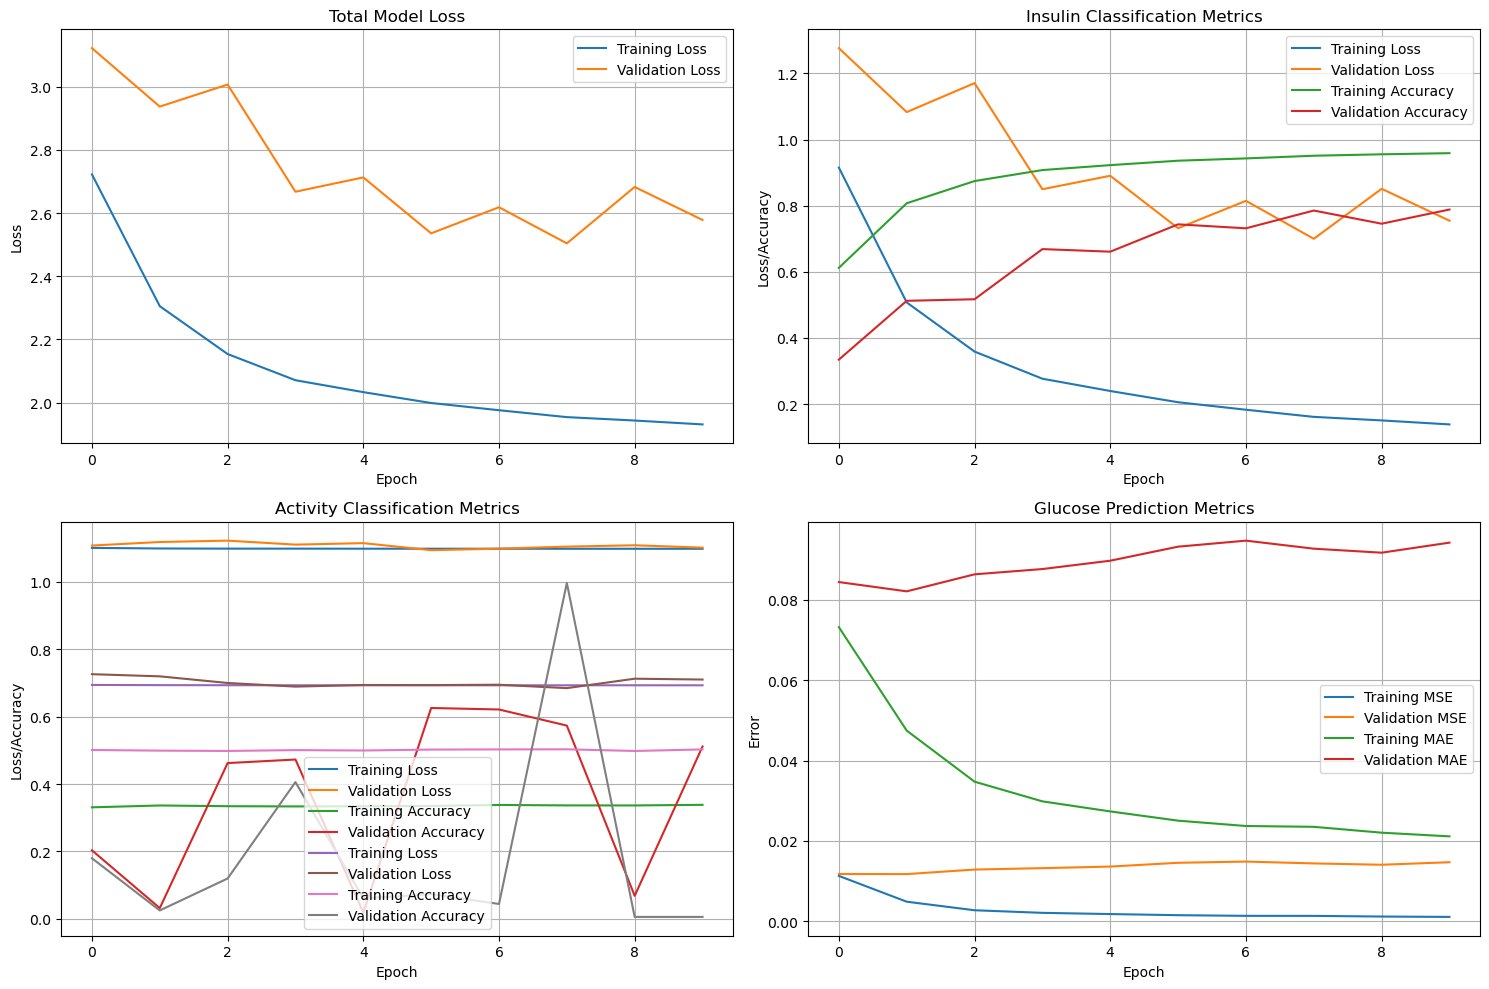

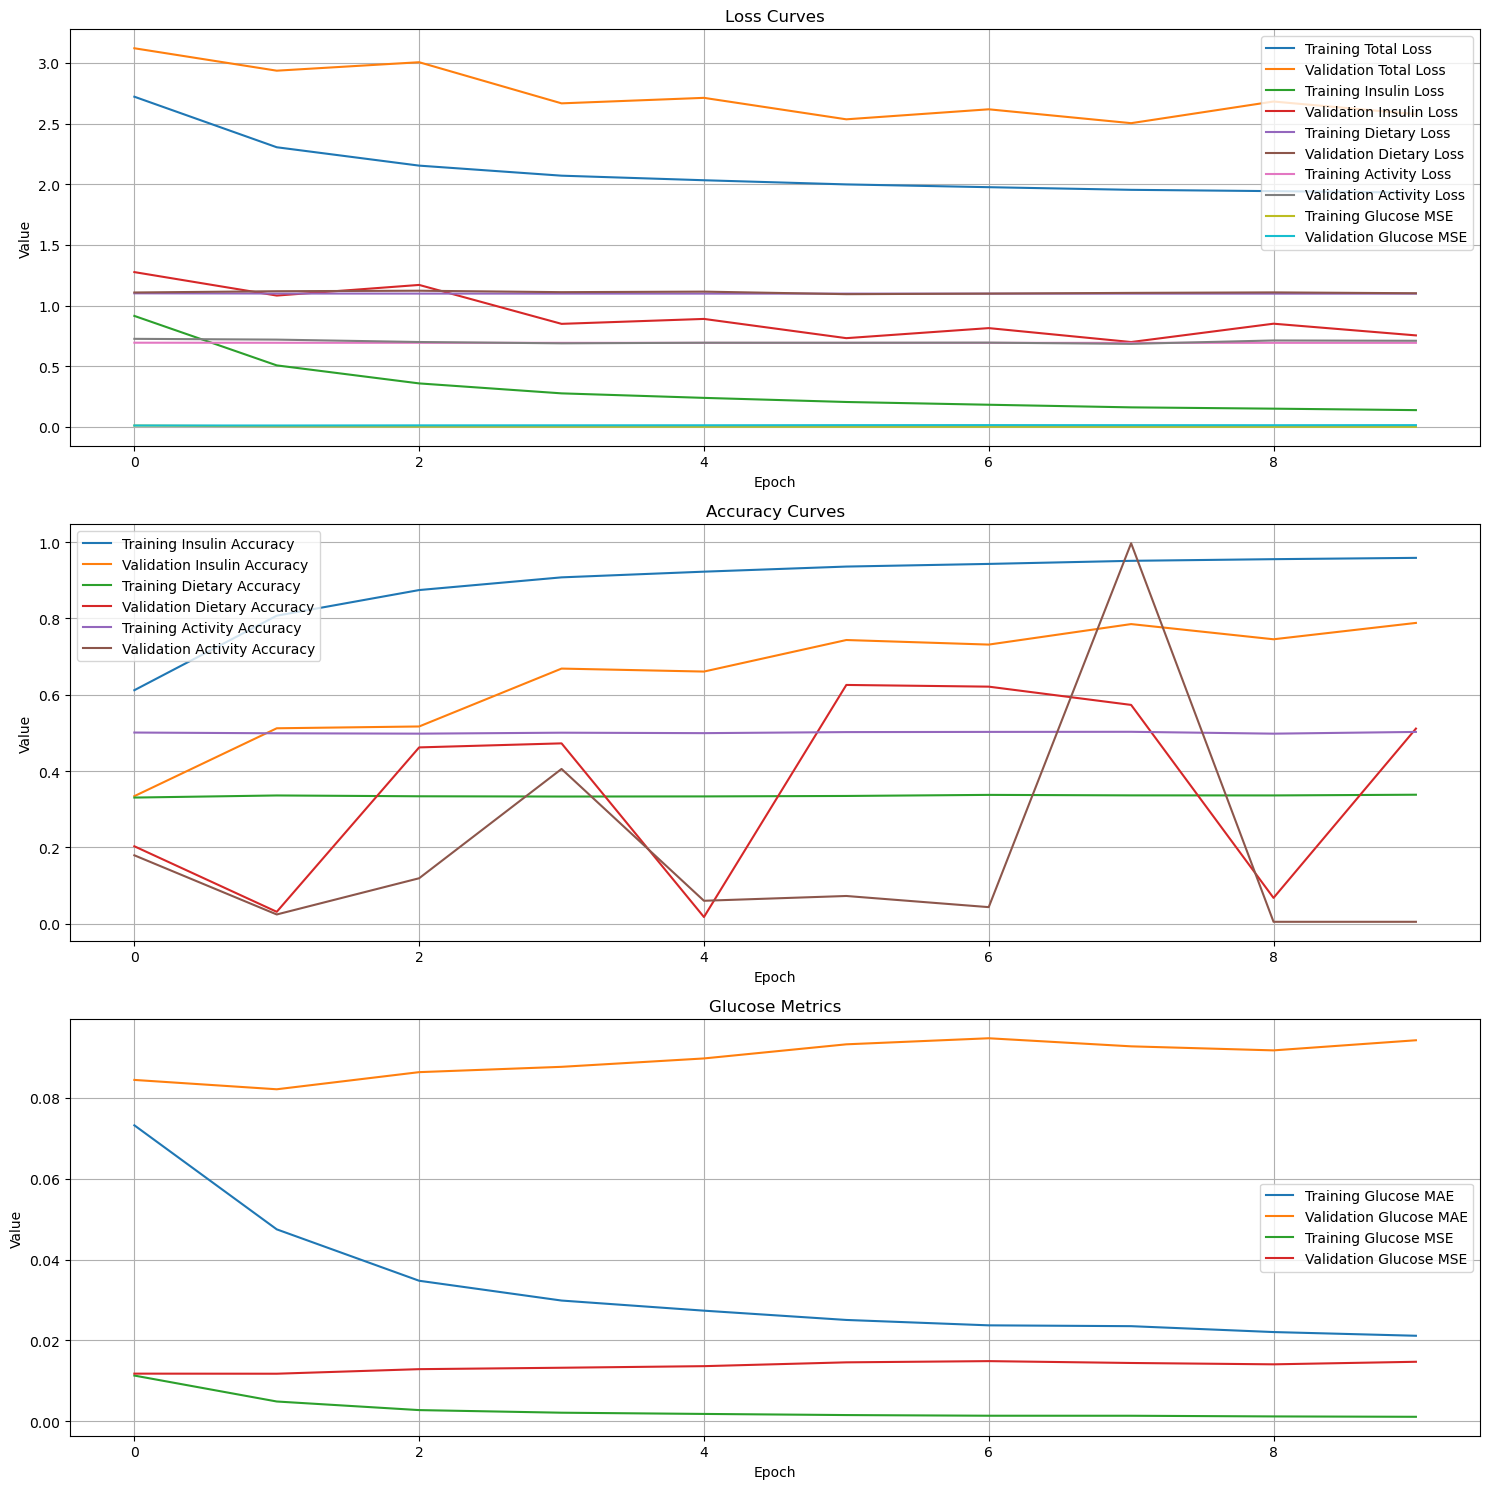


Final Metrics:
--------------------------------------------------

Total Loss:
Training: 1.9314
Validation: 2.5779

Insulin Loss:
Training: 0.1385
Validation: 0.7545

Insulin Accuracy:
Training: 0.9587
Validation: 0.7883

Dietary Loss:
Training: 1.0986
Validation: 1.1020

Dietary Accuracy:
Training: 0.3382
Validation: 0.5114

Activity Loss:
Training: 0.6932
Validation: 0.7102

Activity Accuracy:
Training: 0.5027
Validation: 0.0053

Glucose MSE:
Training: 0.0011
Validation: 0.0147

Glucose MAE:
Training: 0.0212
Validation: 0.0943


In [56]:
visualize_training_history(history)

In [57]:
test_data['index'].unique()

array([140, 171, 256, 301, 354, 360, 436,  67])

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [42]:
# Load the saved model
model = tf.keras.models.load_model('manual_model1.keras')

Creating alert labels for test data...
Created 3594 alert labels for test data
Alert distribution - No Alert: 3086, Alert: 508
Making predictions...
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step
Generated 3594 predicted alert labels
Predicted alert distribution - No Alert: 3320, Alert: 274

Verifying array lengths:
Actual alert labels: 3594
Predicted alert labels: 3594
Test patient IDs: 3594
Test sequences: 3594
Final array lengths after adjustment:
Actual alert labels: 3594
Predicted alert labels: 3594
Test patient IDs: 3594
Test sequence indices: 3594

OVERALL ALERT SYSTEM PERFORMANCE
Unique values in actual alerts: [0 1]
Unique values in predicted alerts: [0 1]
Confusion matrix shape: (2, 2)
Confusion matrix:
[[2906  180]
 [ 414   94]]
Total test samples: 3594
Accuracy: 0.8347
Precision: 0.3431
Recall: 0.1850
F1-Score: 0.2404

Confusion Matrix:
True Positive (Correct Alerts): 94 (0.0262)
False Positive (False Alerts): 180 (0.0501)
False Negative (Missed Alerts): 414 (0.1152)
True Negat

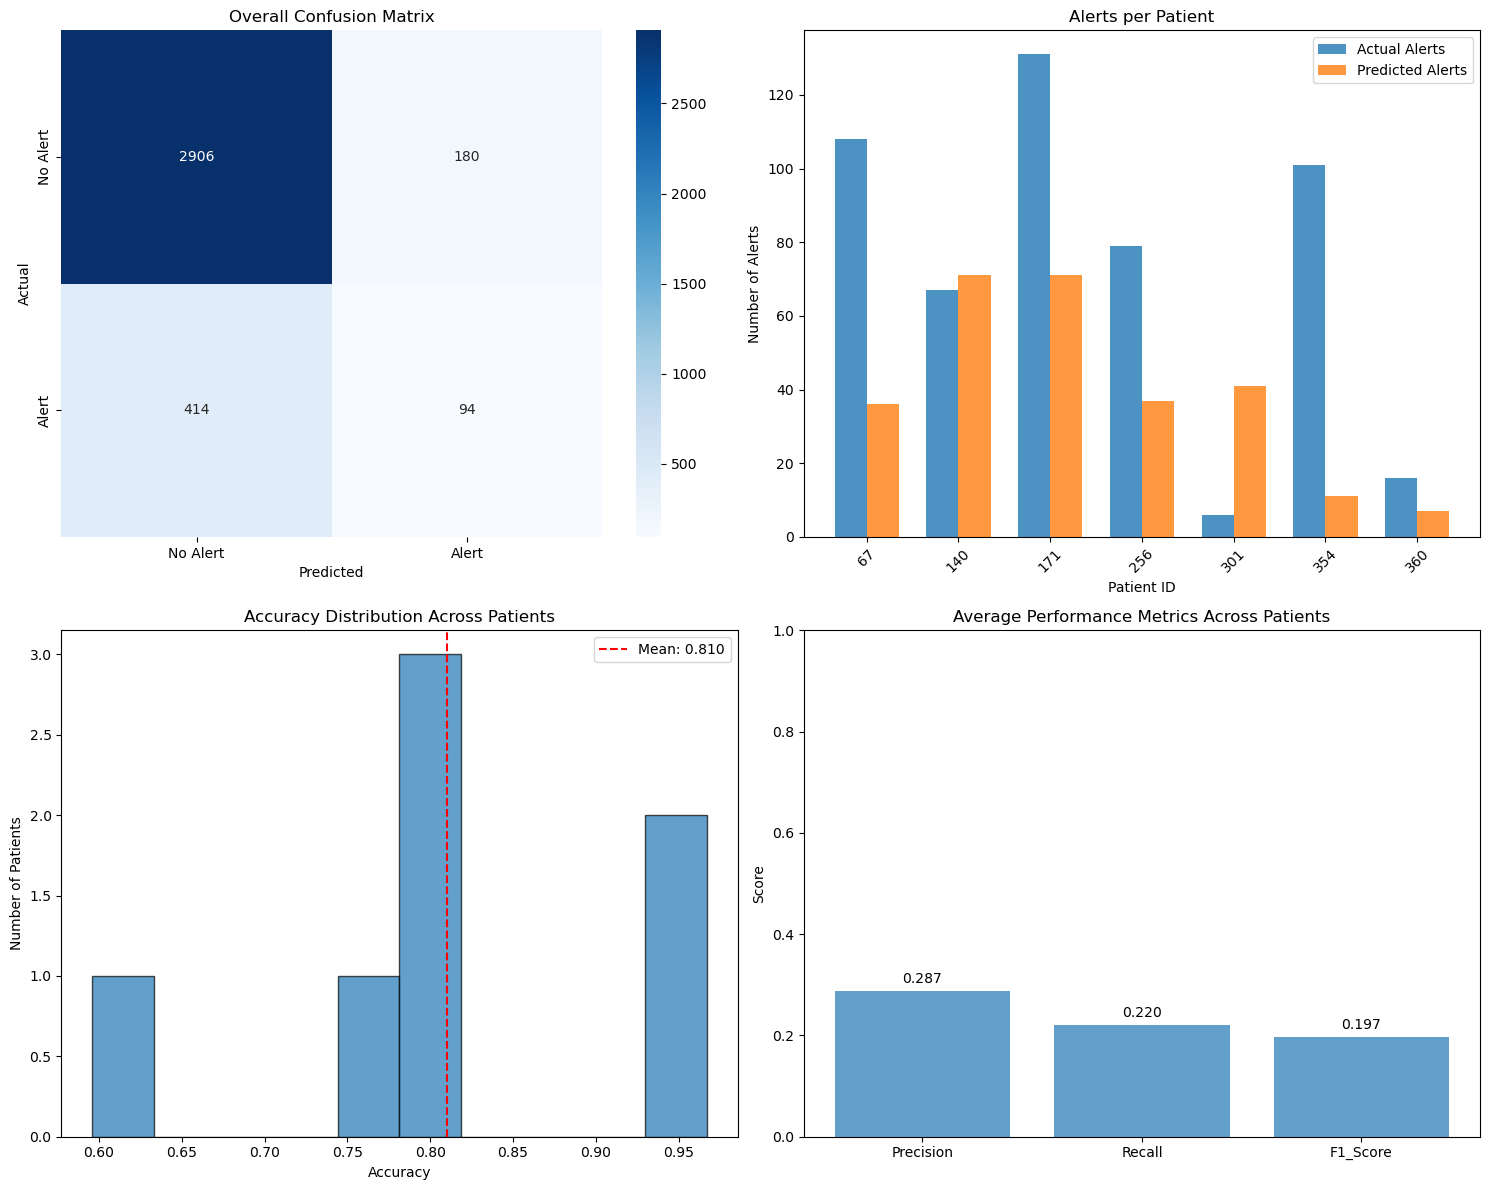


GLUCOSE PREDICTION ANALYSIS
Glucose Prediction Metrics:
Mean Squared Error (MSE): 1872.06
Mean Absolute Error (MAE): 34.17
Root Mean Squared Error (RMSE): 43.27


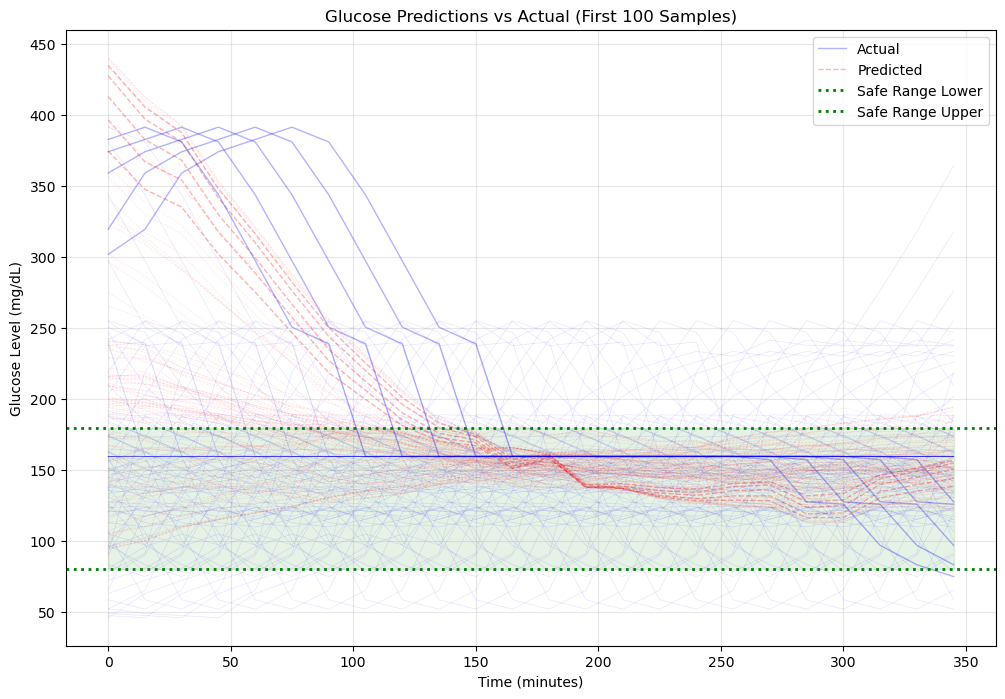


SUMMARY
• Total patients analyzed: 7
• Total test sequences: 3594
• Overall alert system accuracy: 83.5%
• Average patient-level accuracy: 81.0%
• Patients with perfect accuracy: 0
• True positive rate (sensitivity): 2.6%
• False positive rate: 5.0%
• True negative rate (specificity): 80.9%
• False negative rate: 11.5%


In [43]:
def generate_alert_label(glucose_array, safe_range=(80, 180), threshold=1/3):
    """
    Generate alert label based on glucose values outside safe range
    
    Args:
        glucose_array: Array of glucose values
        safe_range: Tuple of (min, max) safe glucose values
        threshold: Fraction of values that need to be outside range to trigger alert
    
    Returns:
        1 if alert needed, 0 if no alert
    """
    # Count values outside safe range
    outside_range = np.sum((glucose_array < safe_range[0]) | (glucose_array > safe_range[1]))
    total_values = len(glucose_array)
    
    # Return 1 if more than threshold fraction are outside range
    return 1 if (outside_range / total_values) > threshold else 0

def create_alert_labels_for_test_data(test_data, features, seq_length, slide_step, glucose_prediction_length):
    """
    Create alert labels for test data based on actual glucose values
    Uses the SAME filtering logic as the original create_sequences function
    """
    alert_labels = []
    glucose_sequences = []
    patient_ids = []
    sequence_indices = []
    
    for patient_id in test_data['index'].unique():
        patient_data = test_data[test_data['index'] == patient_id].sort_values(by='measure_sequence')
        
        seq_count = 0
        for start in range(0, len(patient_data) - seq_length, slide_step):
            # Get the actual glucose values for the next prediction period
            next_hour_glucose = patient_data.iloc[start + seq_length:start + seq_length + glucose_prediction_length]['Glucose'].values
            
            if len(next_hour_glucose) == glucose_prediction_length:
                # Apply the SAME filtering logic as in the original create_sequences function
                # Only include sequences where more than 50% of glucose values are in stable range [80, 180]
                num_in_range = np.sum((next_hour_glucose >= 80) & (next_hour_glucose <= 180))
                if num_in_range > glucose_prediction_length * 0.5:
                    # Generate alert label based on actual glucose values
                    alert_label = generate_alert_label(next_hour_glucose)
                    alert_labels.append(alert_label)
                    glucose_sequences.append(next_hour_glucose)
                    patient_ids.append(patient_id)
                    sequence_indices.append(seq_count)
                    seq_count += 1
    
    return np.array(alert_labels), np.array(glucose_sequences), np.array(patient_ids), np.array(sequence_indices)

# Create alert labels for test data based on actual glucose values
print("Creating alert labels for test data...")
actual_alert_labels, actual_glucose_sequences, test_patient_ids, test_sequence_indices = create_alert_labels_for_test_data(
    test_data, features, seq_length=historical_time_window, 
    slide_step=sliding_window, glucose_prediction_length=glucose_time_window
)

print(f"Created {len(actual_alert_labels)} alert labels for test data")
print(f"Alert distribution - No Alert: {np.sum(actual_alert_labels == 0)}, Alert: {np.sum(actual_alert_labels == 1)}")

def make_predictions_and_generate_alerts(model, test_sequences, glucose_scaler):
    """
    Make predictions using the model and generate alerts from predictions
    """
    # Make predictions
    print("Making predictions...")
    insulin_pred, dietary_pred, activity_pred, glucose_pred = model.predict(test_sequences, verbose=1)
    
    # Inverse transform glucose predictions to original scale
    glucose_pred_original = glucose_scaler.inverse_transform(
        glucose_pred.reshape(-1, 1)).reshape(-1, glucose_time_window)
    
    # Generate alert labels from predictions
    predicted_alert_labels = []
    for glucose_seq in glucose_pred_original:
        alert_label = generate_alert_label(glucose_seq)
        predicted_alert_labels.append(alert_label)
    
    return np.array(predicted_alert_labels), glucose_pred_original

# Make predictions and generate alerts
predicted_alert_labels, predicted_glucose = make_predictions_and_generate_alerts(
    model, ts_sequences, glucose_scaler)

print(f"Generated {len(predicted_alert_labels)} predicted alert labels")
print(f"Predicted alert distribution - No Alert: {np.sum(predicted_alert_labels == 0)}, Alert: {np.sum(predicted_alert_labels == 1)}")

# Verify that we have matching array lengths
print(f"\nVerifying array lengths:")
print(f"Actual alert labels: {len(actual_alert_labels)}")
print(f"Predicted alert labels: {len(predicted_alert_labels)}")
print(f"Test patient IDs: {len(test_patient_ids)}")
print(f"Test sequences: {len(ts_sequences)}")

# Make sure all arrays have the same length
min_length = min(len(actual_alert_labels), len(predicted_alert_labels), len(test_patient_ids))
if len(actual_alert_labels) != len(predicted_alert_labels):
    print(f"\nWarning: Array length mismatch detected!")
    print(f"Truncating all arrays to minimum length: {min_length}")
    actual_alert_labels = actual_alert_labels[:min_length]
    predicted_alert_labels = predicted_alert_labels[:min_length]
    test_patient_ids = test_patient_ids[:min_length]
    test_sequence_indices = test_sequence_indices[:min_length]
    
print(f"Final array lengths after adjustment:")
print(f"Actual alert labels: {len(actual_alert_labels)}")
print(f"Predicted alert labels: {len(predicted_alert_labels)}")
print(f"Test patient IDs: {len(test_patient_ids)}")
print(f"Test sequence indices: {len(test_sequence_indices)}")

def calculate_alert_metrics(actual_alerts, predicted_alerts):
    """
    Calculate performance metrics for alert system
    """
    # Ensure arrays have the same length
    if len(actual_alerts) != len(predicted_alerts):
        min_len = min(len(actual_alerts), len(predicted_alerts))
        print(f"Warning: Truncating arrays to length {min_len} for metrics calculation")
        actual_alerts = actual_alerts[:min_len]
        predicted_alerts = predicted_alerts[:min_len]
    
    # Handle edge case where all predictions are the same class
    unique_actual = np.unique(actual_alerts)
    unique_predicted = np.unique(predicted_alerts)
    
    print(f"Unique values in actual alerts: {unique_actual}")
    print(f"Unique values in predicted alerts: {unique_predicted}")
    
    # Calculate confusion matrix
    cm = confusion_matrix(actual_alerts, predicted_alerts)
    print(f"Confusion matrix shape: {cm.shape}")
    print(f"Confusion matrix:\n{cm}")
    
    # Handle different confusion matrix sizes
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
    elif cm.shape == (1, 1):
        # Only one class present
        if unique_actual[0] == 0 and unique_predicted[0] == 0:
            tn, fp, fn, tp = cm[0,0], 0, 0, 0
        else:
            tn, fp, fn, tp = 0, 0, 0, cm[0,0]
    else:
        # Fallback for unexpected shapes
        tn = cm[0,0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
        fp = cm[0,1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
        fn = cm[1,0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
        tp = cm[1,1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0
    
    # Calculate metrics
    accuracy = accuracy_score(actual_alerts, predicted_alerts)
    precision = precision_score(actual_alerts, predicted_alerts, zero_division=0)
    recall = recall_score(actual_alerts, predicted_alerts, zero_division=0)
    f1 = f1_score(actual_alerts, predicted_alerts, zero_division=0)
    
    # Calculate rates
    total = len(actual_alerts)
    tp_rate = tp / total if total > 0 else 0  # True Positive Rate
    fp_rate = fp / total if total > 0 else 0  # False Positive Rate  
    fn_rate = fn / total if total > 0 else 0  # False Negative Rate
    tn_rate = tn / total if total > 0 else 0  # True Negative Rate
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'true_positive': int(tp),
        'false_positive': int(fp),
        'false_negative': int(fn),
        'true_negative': int(tn),
        'tp_rate': tp_rate,
        'fp_rate': fp_rate,
        'fn_rate': fn_rate,
        'tn_rate': tn_rate,
        'total_samples': total
    }
    
    return metrics

def analyze_patient_alerts(patient_ids, sequence_indices, actual_alerts, predicted_alerts):
    """
    Analyze alerts on a per-patient basis
    """
    # Ensure all arrays have the same length
    min_length = min(len(patient_ids), len(actual_alerts), len(predicted_alerts))
    if not all(len(arr) == min_length for arr in [patient_ids, actual_alerts, predicted_alerts]):
        print(f"Adjusting arrays to minimum length: {min_length}")
        patient_ids = patient_ids[:min_length]
        sequence_indices = sequence_indices[:min_length]
        actual_alerts = actual_alerts[:min_length]
        predicted_alerts = predicted_alerts[:min_length]
    
    patient_results = {}
    unique_patients = np.unique(patient_ids)
    
    for patient_id in unique_patients:
        # Get indices for this patient
        patient_mask = patient_ids == patient_id
        
        # Get alerts for this patient
        patient_actual = actual_alerts[patient_mask]
        patient_predicted = predicted_alerts[patient_mask]
        
        # Calculate metrics for this patient
        if len(patient_actual) > 0 and len(patient_predicted) > 0:
            try:
                patient_metrics = calculate_alert_metrics(patient_actual, patient_predicted)
                patient_results[patient_id] = {
                    'metrics': patient_metrics,
                    'num_sequences': len(patient_actual),
                    'actual_alerts': patient_actual,
                    'predicted_alerts': patient_predicted
                }
            except Exception as e:
                print(f"Error calculating metrics for patient {patient_id}: {e}")
                # Create default metrics
                patient_results[patient_id] = {
                    'metrics': {
                        'accuracy': 0.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0.0,
                        'true_positive': 0, 'false_positive': 0, 'false_negative': 0, 'true_negative': 0,
                        'tp_rate': 0.0, 'fp_rate': 0.0, 'fn_rate': 0.0, 'tn_rate': 0.0,
                        'total_samples': len(patient_actual)
                    },
                    'num_sequences': len(patient_actual),
                    'actual_alerts': patient_actual,
                    'predicted_alerts': patient_predicted
                }
    
    return patient_results

# Calculate overall metrics
print("\n" + "="*60)
print("OVERALL ALERT SYSTEM PERFORMANCE")
print("="*60)

overall_metrics = calculate_alert_metrics(actual_alert_labels, predicted_alert_labels)

print(f"Total test samples: {overall_metrics['total_samples']}")
print(f"Accuracy: {overall_metrics['accuracy']:.4f}")
print(f"Precision: {overall_metrics['precision']:.4f}")
print(f"Recall: {overall_metrics['recall']:.4f}")
print(f"F1-Score: {overall_metrics['f1_score']:.4f}")
print()
print("Confusion Matrix:")
print(f"True Positive (Correct Alerts): {overall_metrics['true_positive']} ({overall_metrics['tp_rate']:.4f})")
print(f"False Positive (False Alerts): {overall_metrics['false_positive']} ({overall_metrics['fp_rate']:.4f})")
print(f"False Negative (Missed Alerts): {overall_metrics['false_negative']} ({overall_metrics['fn_rate']:.4f})")
print(f"True Negative (Correct No-Alerts): {overall_metrics['true_negative']} ({overall_metrics['tn_rate']:.4f})")

# Analyze per-patient results
print("\n" + "="*60)
print("PER-PATIENT ALERT ANALYSIS")
print("="*60)

patient_results = analyze_patient_alerts(test_patient_ids, test_sequence_indices, 
                                       actual_alert_labels, predicted_alert_labels)

# Summary statistics per patient
patient_summary = []
for patient_id, results in patient_results.items():
    metrics = results['metrics']
    num_sequences = results['num_sequences']
    total_actual_alerts = np.sum(results['actual_alerts'])
    total_predicted_alerts = np.sum(results['predicted_alerts'])
    
    patient_summary.append({
        'Patient_ID': patient_id,
        'Num_Sequences': num_sequences,
        'Actual_Alerts': total_actual_alerts,
        'Predicted_Alerts': total_predicted_alerts,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1_Score': metrics['f1_score'],
        'TP': metrics['true_positive'],
        'FP': metrics['false_positive'],
        'FN': metrics['false_negative'],
        'TN': metrics['true_negative']
    })

# Convert to DataFrame for easy viewing
patient_summary_df = pd.DataFrame(patient_summary)
print("\nPatient Summary:")
print(patient_summary_df.to_string(index=False))

# Show detailed results for first few patients
print("\n" + "="*60)
print("DETAILED RESULTS FOR FIRST 5 PATIENTS")
print("="*60)

for i, (patient_id, results) in enumerate(list(patient_results.items())[:5]):
    print(f"\nPatient {patient_id}:")
    print(f"  Number of sequences: {results['num_sequences']}")
    print(f"  Actual alerts: {np.sum(results['actual_alerts'])}/{len(results['actual_alerts'])}")
    print(f"  Predicted alerts: {np.sum(results['predicted_alerts'])}/{len(results['predicted_alerts'])}")
    print(f"  Accuracy: {results['metrics']['accuracy']:.4f}")
    print(f"  True Positives: {results['metrics']['true_positive']}")
    print(f"  False Positives: {results['metrics']['false_positive']}")
    print(f"  False Negatives: {results['metrics']['false_negative']}")
    print(f"  True Negatives: {results['metrics']['true_negative']}")

def plot_alert_analysis():
    """
    Create visualizations for alert analysis
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Overall confusion matrix
    cm = confusion_matrix(actual_alert_labels, predicted_alert_labels)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[0,0], cmap='Blues',
                xticklabels=['No Alert', 'Alert'], yticklabels=['No Alert', 'Alert'])
    axes[0,0].set_title('Overall Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # 2. Alert distribution by patient
    patient_alert_counts = patient_summary_df[['Patient_ID', 'Actual_Alerts', 'Predicted_Alerts']]
    x = np.arange(len(patient_alert_counts))
    width = 0.35
    
    axes[0,1].bar(x - width/2, patient_alert_counts['Actual_Alerts'], width, 
                  label='Actual Alerts', alpha=0.8)
    axes[0,1].bar(x + width/2, patient_alert_counts['Predicted_Alerts'], width, 
                  label='Predicted Alerts', alpha=0.8)
    axes[0,1].set_xlabel('Patient ID')
    axes[0,1].set_ylabel('Number of Alerts')
    axes[0,1].set_title('Alerts per Patient')
    axes[0,1].set_xticks(x)
    axes[0,1].set_xticklabels(patient_alert_counts['Patient_ID'], rotation=45)
    axes[0,1].legend()
    
    # 3. Accuracy distribution across patients
    axes[1,0].hist(patient_summary_df['Accuracy'], bins=10, edgecolor='black', alpha=0.7)
    axes[1,0].set_xlabel('Accuracy')
    axes[1,0].set_ylabel('Number of Patients')
    axes[1,0].set_title('Accuracy Distribution Across Patients')
    axes[1,0].axvline(patient_summary_df['Accuracy'].mean(), color='red', 
                      linestyle='--', label=f'Mean: {patient_summary_df["Accuracy"].mean():.3f}')
    axes[1,0].legend()
    
    # 4. Performance metrics comparison
    metrics_names = ['Precision', 'Recall', 'F1_Score']
    metrics_values = [patient_summary_df[metric].mean() for metric in metrics_names]
    
    axes[1,1].bar(metrics_names, metrics_values, alpha=0.7)
    axes[1,1].set_ylabel('Score')
    axes[1,1].set_title('Average Performance Metrics Across Patients')
    axes[1,1].set_ylim(0, 1)
    
    # Add value labels on bars
    for i, v in enumerate(metrics_values):
        axes[1,1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
plot_alert_analysis()

def analyze_glucose_predictions_vs_actual():
    """
    Compare predicted glucose values vs actual glucose values
    """
    print("\n" + "="*60)
    print("GLUCOSE PREDICTION ANALYSIS")
    print("="*60)
    
    # Convert actual glucose sequences back to original scale for comparison
    actual_glucose_original = glucose_scaler.inverse_transform(
        ts_glucose_targets.reshape(-1, 1)).reshape(-1, glucose_time_window)
    
    # Calculate glucose prediction metrics
    mse = np.mean((actual_glucose_original - predicted_glucose) ** 2)
    mae = np.mean(np.abs(actual_glucose_original - predicted_glucose))
    rmse = np.sqrt(mse)
    
    print(f"Glucose Prediction Metrics:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    
    # Plot glucose predictions vs actual
    plt.figure(figsize=(12, 8))
    
    # Plot first 100 samples for clarity
    n_samples = min(100, len(actual_glucose_original))
    time_points = np.arange(glucose_time_window) * 15  # 15-minute intervals
    
    for i in range(n_samples):
        if i < 5:  # Show only first 5 for legend clarity
            plt.plot(time_points, actual_glucose_original[i], 'b-', alpha=0.3, 
                    label='Actual' if i == 0 else "", linewidth=1)
            plt.plot(time_points, predicted_glucose[i], 'r--', alpha=0.3, 
                    label='Predicted' if i == 0 else "", linewidth=1)
        else:
            plt.plot(time_points, actual_glucose_original[i], 'b-', alpha=0.1, linewidth=0.5)
            plt.plot(time_points, predicted_glucose[i], 'r--', alpha=0.1, linewidth=0.5)
    
    # Add safe range
    plt.axhline(y=80, color='green', linestyle=':', label='Safe Range Lower', linewidth=2)
    plt.axhline(y=180, color='green', linestyle=':', label='Safe Range Upper', linewidth=2)
    plt.fill_between(time_points, 80, 180, alpha=0.1, color='green')
    
    plt.xlabel('Time (minutes)')
    plt.ylabel('Glucose Level (mg/dL)')
    plt.title(f'Glucose Predictions vs Actual (First {n_samples} Samples)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Analyze glucose predictions
analyze_glucose_predictions_vs_actual()

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"• Total patients analyzed: {len(patient_results)}")
print(f"• Total test sequences: {len(actual_alert_labels)}")
print(f"• Overall alert system accuracy: {overall_metrics['accuracy']:.1%}")
print(f"• Average patient-level accuracy: {patient_summary_df['Accuracy'].mean():.1%}")
print(f"• Patients with perfect accuracy: {np.sum(patient_summary_df['Accuracy'] == 1.0)}")
print(f"• True positive rate (sensitivity): {overall_metrics['tp_rate']:.1%}")
print(f"• False positive rate: {overall_metrics['fp_rate']:.1%}")
print(f"• True negative rate (specificity): {overall_metrics['tn_rate']:.1%}")
print(f"• False negative rate: {overall_metrics['fn_rate']:.1%}")

In [46]:
patient_summary_df['Predicted_Alerts'].sum()

np.int64(274)

In [47]:
274/3594

0.07623817473567056


ALERT RATIO ANALYSIS BY GLUCOSE LEVEL
Median glucose level across all patients: 130.0 mg/dL
High glucose patients (>130.0 mg/dL): 6
Low glucose patients (≤130.0 mg/dL): 2

HIGH GLUCOSE Group Results:
  Number of patients: 6
  Total sequences: 2218
  Total predicted alerts: 226
  Total real alerts: 486
  Predicted alert ratio: 0.102 (10.2%)
  Real alert ratio: 0.219 (21.9%)
  Ratio difference (predicted - real): -0.117

LOW GLUCOSE Group Results:
  Number of patients: 2
  Total sequences: 1376
  Total predicted alerts: 48
  Total real alerts: 22
  Predicted alert ratio: 0.035 (3.5%)
  Real alert ratio: 0.016 (1.6%)
  Ratio difference (predicted - real): 0.019

--------------------------------------------------
GROUP COMPARISON:
--------------------------------------------------
Predicted alert ratio - High vs Low: 0.102 vs 0.035
Real alert ratio - High vs Low: 0.219 vs 0.016
Predicted ratio difference (High - Low): 0.067
Real ratio difference (High - Low): 0.203

Statistical test for p

ValueError: x and y must be the same size

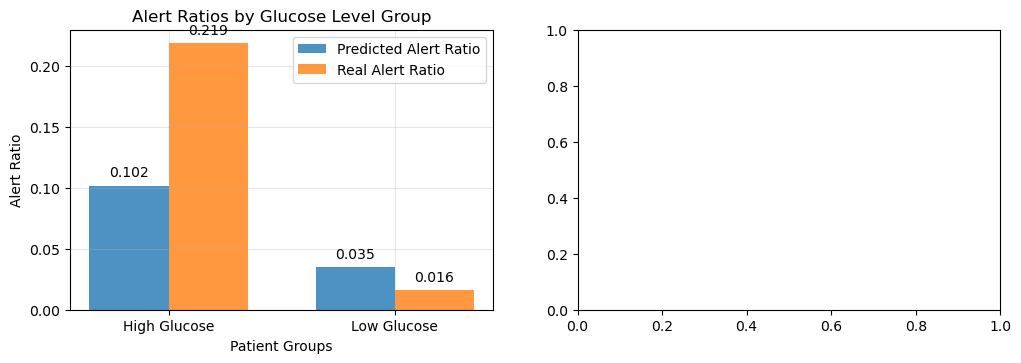

In [45]:
def analyze_alert_ratios_by_glucose_level():
    """
    Analyze alert ratios for patients with high vs low average glucose levels
    """
    print("\n" + "="*60)
    print("ALERT RATIO ANALYSIS BY GLUCOSE LEVEL")
    print("="*60)
    
    # Calculate average glucose level for each patient from the test data
    patient_glucose_averages = {}
    
    for patient_id in test_data['index'].unique():
        patient_data = test_data[test_data['index'] == patient_id]
        avg_glucose = patient_data['Glucose'].mean()
        patient_glucose_averages[patient_id] = avg_glucose
    
    # Convert to arrays for easier manipulation
    patient_ids_all = list(patient_glucose_averages.keys())
    glucose_averages = list(patient_glucose_averages.values())
    
    # Calculate median glucose level to split patients into high/low groups
    median_glucose = 130
    print(f"Median glucose level across all patients: {median_glucose:.1f} mg/dL")
    
    # Alternative: use clinical thresholds (uncomment if preferred)
    # Normal range is typically 80-140 mg/dL, so we could use 140 as threshold
    # threshold_glucose = 140
    # print(f"Using clinical threshold: {threshold_glucose} mg/dL")
    
    # Categorize patients
    high_glucose_patients = [pid for pid, avg_gluc in patient_glucose_averages.items() 
                           if avg_gluc > median_glucose]
    low_glucose_patients = [pid for pid, avg_gluc in patient_glucose_averages.items() 
                          if avg_gluc <= median_glucose]
    
    print(f"High glucose patients (>{median_glucose:.1f} mg/dL): {len(high_glucose_patients)}")
    print(f"Low glucose patients (≤{median_glucose:.1f} mg/dL): {len(low_glucose_patients)}")
    
    # Calculate alert ratios for each group
    def calculate_group_ratios(patient_group, group_name):
        group_data = {
            'total_sequences': 0,
            'predicted_alerts': 0,
            'real_alerts': 0,
            'patients': []
        }
        
        for patient_id in patient_group:
            if patient_id in patient_results:
                patient_info = patient_results[patient_id]
                num_sequences = patient_info['num_sequences']
                predicted_alerts = np.sum(patient_info['predicted_alerts'])
                real_alerts = np.sum(patient_info['actual_alerts'])
                
                group_data['total_sequences'] += num_sequences
                group_data['predicted_alerts'] += predicted_alerts
                group_data['real_alerts'] += real_alerts
                
                # Store individual patient data
                group_data['patients'].append({
                    'patient_id': patient_id,
                    'avg_glucose': patient_glucose_averages[patient_id],
                    'num_sequences': num_sequences,
                    'predicted_alerts': predicted_alerts,
                    'real_alerts': real_alerts,
                    'predicted_ratio': predicted_alerts / num_sequences if num_sequences > 0 else 0,
                    'real_ratio': real_alerts / num_sequences if num_sequences > 0 else 0
                })
        
        # Calculate group ratios
        predicted_ratio = (group_data['predicted_alerts'] / group_data['total_sequences'] 
                          if group_data['total_sequences'] > 0 else 0)
        real_ratio = (group_data['real_alerts'] / group_data['total_sequences'] 
                     if group_data['total_sequences'] > 0 else 0)
        
        print(f"\n{group_name} Group Results:")
        print(f"  Number of patients: {len(patient_group)}")
        print(f"  Total sequences: {group_data['total_sequences']}")
        print(f"  Total predicted alerts: {group_data['predicted_alerts']}")
        print(f"  Total real alerts: {group_data['real_alerts']}")
        print(f"  Predicted alert ratio: {predicted_ratio:.3f} ({predicted_ratio*100:.1f}%)")
        print(f"  Real alert ratio: {real_ratio:.3f} ({real_ratio*100:.1f}%)")
        print(f"  Ratio difference (predicted - real): {predicted_ratio - real_ratio:.3f}")
        
        return group_data, predicted_ratio, real_ratio
    
    # Analyze both groups
    high_group_data, high_pred_ratio, high_real_ratio = calculate_group_ratios(
        high_glucose_patients, "HIGH GLUCOSE")
    low_group_data, low_pred_ratio, low_real_ratio = calculate_group_ratios(
        low_glucose_patients, "LOW GLUCOSE")
    
    # Compare between groups
    print(f"\n" + "-"*50)
    print("GROUP COMPARISON:")
    print("-"*50)
    print(f"Predicted alert ratio - High vs Low: {high_pred_ratio:.3f} vs {low_pred_ratio:.3f}")
    print(f"Real alert ratio - High vs Low: {high_real_ratio:.3f} vs {low_real_ratio:.3f}")
    print(f"Predicted ratio difference (High - Low): {high_pred_ratio - low_pred_ratio:.3f}")
    print(f"Real ratio difference (High - Low): {high_real_ratio - low_real_ratio:.3f}")
    
    # Statistical significance test (if applicable)
    if len(high_glucose_patients) > 1 and len(low_glucose_patients) > 1:
        from scipy import stats
        
        # Get individual patient ratios for statistical testing
        high_pred_ratios = [p['predicted_ratio'] for p in high_group_data['patients']]
        low_pred_ratios = [p['predicted_ratio'] for p in low_group_data['patients']]
        high_real_ratios = [p['real_ratio'] for p in high_group_data['patients']]
        low_real_ratios = [p['real_ratio'] for p in low_group_data['patients']]
        
        # T-test for predicted ratios
        try:
            t_stat_pred, p_val_pred = stats.ttest_ind(high_pred_ratios, low_pred_ratios)
            print(f"\nStatistical test for predicted ratios:")
            print(f"  T-statistic: {t_stat_pred:.3f}, p-value: {p_val_pred:.3f}")
            print(f"  Significant difference: {'Yes' if p_val_pred < 0.05 else 'No'}")
        except:
            print("\nCannot perform statistical test for predicted ratios")
        
        # T-test for real ratios
        try:
            t_stat_real, p_val_real = stats.ttest_ind(high_real_ratios, low_real_ratios)
            print(f"\nStatistical test for real ratios:")
            print(f"  T-statistic: {t_stat_real:.3f}, p-value: {p_val_real:.3f}")
            print(f"  Significant difference: {'Yes' if p_val_real < 0.05 else 'No'}")
        except:
            print("\nCannot perform statistical test for real ratios")
    
    # Create visualization
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Bar chart comparing ratios
    plt.subplot(2, 2, 1)
    groups = ['High Glucose', 'Low Glucose']
    predicted_ratios = [high_pred_ratio, low_pred_ratio]
    real_ratios = [high_real_ratio, low_real_ratio]
    
    x = np.arange(len(groups))
    width = 0.35
    
    plt.bar(x - width/2, predicted_ratios, width, label='Predicted Alert Ratio', alpha=0.8)
    plt.bar(x + width/2, real_ratios, width, label='Real Alert Ratio', alpha=0.8)
    
    plt.xlabel('Patient Groups')
    plt.ylabel('Alert Ratio')
    plt.title('Alert Ratios by Glucose Level Group')
    plt.xticks(x, groups)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, (pred, real) in enumerate(zip(predicted_ratios, real_ratios)):
        plt.text(i - width/2, pred + 0.005, f'{pred:.3f}', ha='center', va='bottom')
        plt.text(i + width/2, real + 0.005, f'{real:.3f}', ha='center', va='bottom')
    
    # Plot 2: Scatter plot of individual patients
    plt.subplot(2, 2, 2)
    high_glucose_vals = [patient_glucose_averages[pid] for pid in high_glucose_patients]
    high_pred_ratios = [p['predicted_ratio'] for p in high_group_data['patients']]
    low_glucose_vals = [patient_glucose_averages[pid] for pid in low_glucose_patients]
    low_pred_ratios = [p['predicted_ratio'] for p in low_group_data['patients']]
    
    plt.scatter(high_glucose_vals, high_pred_ratios, alpha=0.6, label='High Glucose', s=50)
    plt.scatter(low_glucose_vals, low_pred_ratios, alpha=0.6, label='Low Glucose', s=50)
    plt.axvline(x=median_glucose, color='red', linestyle='--', alpha=0.7, label='Median Glucose')
    
    plt.xlabel('Average Glucose Level (mg/dL)')
    plt.ylabel('Predicted Alert Ratio')
    plt.title('Predicted Alert Ratio vs Average Glucose')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Scatter plot for real ratios
    plt.subplot(2, 2, 3)
    high_real_ratios = [p['real_ratio'] for p in high_group_data['patients']]
    low_real_ratios = [p['real_ratio'] for p in low_group_data['patients']]
    
    plt.scatter(high_glucose_vals, high_real_ratios, alpha=0.6, label='High Glucose', s=50)
    plt.scatter(low_glucose_vals, low_real_ratios, alpha=0.6, label='Low Glucose', s=50)
    plt.axvline(x=median_glucose, color='red', linestyle='--', alpha=0.7, label='Median Glucose')
    
    plt.xlabel('Average Glucose Level (mg/dL)')
    plt.ylabel('Real Alert Ratio')
    plt.title('Real Alert Ratio vs Average Glucose')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Distribution of glucose levels
    plt.subplot(2, 2, 4)
    plt.hist(glucose_averages, bins=15, alpha=0.7, edgecolor='black')
    plt.axvline(x=median_glucose, color='red', linestyle='--', linewidth=2, label=f'Median: {median_glucose:.1f}')
    plt.xlabel('Average Glucose Level (mg/dL)')
    plt.ylabel('Number of Patients')
    plt.title('Distribution of Patient Average Glucose Levels')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed patient information for verification
    print(f"\n" + "="*60)
    print("DETAILED PATIENT BREAKDOWN")
    print("="*60)
    
    print(f"\nHIGH GLUCOSE PATIENTS (top 5):")
    high_patients_sorted = sorted(high_group_data['patients'], 
                                key=lambda x: x['avg_glucose'], reverse=True)
    for i, patient in enumerate(high_patients_sorted[:5]):
        print(f"  Patient {patient['patient_id']}: "
              f"Avg glucose={patient['avg_glucose']:.1f}, "
              f"Sequences={patient['num_sequences']}, "
              f"Pred ratio={patient['predicted_ratio']:.3f}, "
              f"Real ratio={patient['real_ratio']:.3f}")
    
    print(f"\nLOW GLUCOSE PATIENTS (bottom 5):")
    low_patients_sorted = sorted(low_group_data['patients'], 
                               key=lambda x: x['avg_glucose'])
    for i, patient in enumerate(low_patients_sorted[:5]):
        print(f"  Patient {patient['patient_id']}: "
              f"Avg glucose={patient['avg_glucose']:.1f}, "
              f"Sequences={patient['num_sequences']}, "
              f"Pred ratio={patient['predicted_ratio']:.3f}, "
              f"Real ratio={patient['real_ratio']:.3f}")

# Run the glucose level analysis
analyze_alert_ratios_by_glucose_level()